<a href="https://colab.research.google.com/github/s183796/AIStudentProjects/blob/christine/UNet_3d_with_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
import numpy as np
%matplotlib nbagg
%matplotlib inline
import seaborn as sns
import pandas as pd
import torch
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu
from torch.nn.functional import softmax
import PIL.Image
import os
import torchvision
import cv2

from torchvision import transforms
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, Dataset, Subset

import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms.functional as TF
import glob

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
class UNet(nn.Module): #from https://towardsdatascience.com/cook-your-first-u-net-in-pytorch-b3297a844cf3
    def __init__(self, n_class):
        super().__init__()

        # Encoder
        # In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image.
        # Each block in the encoder consists of two convolutional layers followed by a max-pooling layer, with the exception of the last block which does not include a max-pooling layer.
        # -------
        # input: 1x128x128
        self.e11 = nn.Conv3d(1, 64, kernel_size=3,padding=1)
        self.e12 = nn.Conv3d(64, 64, kernel_size=3,padding=1)
        self.pool1 = nn.MaxPool3d(kernel_size=2, stride=2) #64x64x64

        self.e21 = nn.Conv3d(64, 128, kernel_size=3,padding=1)
        self.e22 = nn.Conv3d(128, 128, kernel_size=3,padding=1)
        self.pool2 = nn.MaxPool3d(kernel_size=2, stride=2) #32x32x128

        self.e31 = nn.Conv3d(128, 256, kernel_size=3,padding=1)
        self.e32 = nn.Conv3d(256, 256, kernel_size=3,padding=1)
        self.pool3 = nn.MaxPool3d(kernel_size=2, stride=2) #16x16x256

        self.e41 = nn.Conv3d(256, 512, kernel_size=3,padding=1)
        self.e42 = nn.Conv3d(512, 512, kernel_size=3,padding=1)

        '''
        self.pool4 = nn.MaxPool3d(kernel_size=2, stride=2) #8x8x512


        self.e51 = nn.Conv3d(512, 1024, kernel_size=3,padding=1)
        self.e52 = nn.Conv3d(1024, 1024, kernel_size=3,padding=1)

        self.upconv1 = nn.ConvTranspose3d(1024,512,kernel_size=2,stride=2) #16x16x1024
        self.d11 = nn.Conv3d(1024,512,kernel_size=3,padding=1)
        self.d12 = nn.Conv3d(512,512,kernel_size=3,padding=1)
        '''
        self.upconv2 = nn.ConvTranspose3d(512,256,kernel_size=2,stride=2) #
        self.d21 = nn.Conv3d(512,256,kernel_size=3,padding=1)
        self.d22 = nn.Conv3d(256,256,kernel_size=3,padding=1)

        self.upconv3 = nn.ConvTranspose3d(256,128,kernel_size=2,stride=2)
        self.d31 = nn.Conv3d(256,128,kernel_size=3,padding=1)
        self.d32 = nn.Conv3d(128,128,kernel_size=3,padding=1)

        self.upconv4 = nn.ConvTranspose3d(128,64,kernel_size=2,stride=2)
        self.d41 = nn.Conv3d(128,64,kernel_size=3,padding=1)
        self.d42 = nn.Conv3d(64,64,kernel_size=3,padding=1)

        self.outconv = nn.Conv3d(64, n_class, kernel_size=1)

    def forward(self, x):
        # Encoder
        xe11 = F.relu(self.e11(x))
        xe12 = F.relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = F.relu(self.e21(xp1))
        xe22 = F.relu(self.e22(xe21))
        xp2 = self.pool2(xe22)


        xe31 = F.relu(self.e31(xp2))
        xe32 = F.relu(self.e32(xe31))

        xp3 = self.pool3(xe32)

        xe41 = F.relu(self.e41(xp3))
        xe42 = F.relu(self.e42(xe41))


        #xp4 = self.pool4(xe42)

        #xe51 = F.relu(self.e51(xp4))
        #xe52 = F.relu(self.e52(xe51))

        # Up-convolutions
        #xup1 = self.upconv1(xe52)
        #xcat=xup1
        #xcat = torch.cat([xup1, xe42], dim=1)

        #xup21 = F.relu(self.d11(xcat))
        #xup22 = F.relu(self.d12(xup21))

        xup2 = self.upconv2(xe42)
        #xcat2=xup2
        #xcat2 = torch.cat([xup2, xe32[:,:,:-1,:-1]], dim=1)
        xcat2 = torch.cat([xup2, xe32], dim=1)


        xup31 = F.relu(self.d21(xcat2))
        xup32 = F.relu(self.d22(xup31))
        xup3 = self.upconv3(xup32)
        #xcat3=xup3
        xcat3 = torch.cat([xup3, xe22], dim=1)

        xup41 = F.relu(self.d31(xcat3))
        xup42 = F.relu(self.d32(xup41))

        xup4 = self.upconv4(xup42)
        #xcat4 = torch.cat([xup4, xe12[:,:,2:-3,2:-3]], dim=1)
        xcat4 = torch.cat([xup4, xe12], dim=1)
        xup51 = F.relu(self.d41(xcat4))
        xup52 = F.relu(self.d42(xup51))

        out = self.outconv(xup52)

        output = softmax(out,dim=1)

        return output

In [42]:
#Setting up hyper parameters, from exercise week 6


loss_fn =  nn.CrossEntropyLoss()         # <-- Your code here.

import random


In [43]:
class SOCDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.image_folder = os.path.join(root_dir, 'data/')
        self.label_folder = os.path.join(root_dir, 'labels/')
        self.image_filenames = sorted([f for f in os.listdir(self.image_folder) if f.endswith('.tiff')])
        self.label_filenames = sorted([f for f in os.listdir(self.label_folder) if f.endswith('.tif')])

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
      img_name = os.path.join(self.image_folder, self.image_filenames[idx])

      number1=img_name[-8:-5]
      label_name=os.path.join(self.label_folder,'slice__'+str(number1)+'.tif')

      image = cv2.imread(img_name, cv2.IMREAD_GRAYSCALE)
      label = cv2.imread(label_name, cv2.IMREAD_GRAYSCALE)
      image=torch.from_numpy(np.array(image))
      label=torch.from_numpy(np.array(label))

      return image, label

In [44]:
SOC_dataset = SOCDataset(root_dir='drive/My Drive//AI data/')

images=[]
labels=[]
for i in range(len(SOC_dataset)):
  image,label=SOC_dataset[i]

  images.append(image)
  labels.append(label)



In [45]:
#creating volumes
im_vol=torch.stack(images)
labels_vol=torch.stack(labels)

In [46]:
def split_cube(volume,n):
  size_vol=im_vol.size()

  patches=volume.unfold(2, n, n).unfold(1, n, n).unfold(0, n, n)
  patches = patches.contiguous().view(-1, n, n, n)

  return patches


In [47]:
#Creating sub volumes
im_vol=split_cube(im_vol,64)
label_vol=split_cube(labels_vol,64)

im_vol.size()


torch.Size([343, 64, 64, 64])

In [48]:
pip install torchio

In [49]:
import torchio as tio
from re import I
subjects = []
for i in range(im_vol.size(0)):
    subject = tio.Subject(
        image_sub=tio.ScalarImage(tensor=im_vol.unsqueeze(0)[:,i,:,:]),
        label_sub=tio.LabelMap(tensor=label_vol.unsqueeze(0)[:,i,:,:]),
    )
    subjects.append(subject)
dataset = tio.SubjectsDataset(subjects)
print('Dataset size:', len(dataset), 'subjects')

Dataset size: 343 subjects


In [50]:
#From https://torchio.readthedocs.io/transforms/transforms.html
transforms = (
    tio.CropOrPad((32, 32, 32)),
    #tio.RandomFlip(axes=['LR', 'AP', 'IS']),
    tio.ZNormalization(masking_method=tio.ZNormalization.mean)
)

transform = tio.Compose(transforms)

In [51]:
#Splitting in training and test data

training_split_ratio=0.7
num_subjects = len(dataset)

num_training_subjects = int(training_split_ratio * num_subjects)
num_validation_subjects = num_subjects - num_training_subjects
num_test_subjects = num_validation_subjects*0.5

num_split_subjects = num_training_subjects, num_validation_subjects
training_subjects, validation_subjects = torch.utils.data.random_split(subjects, num_split_subjects)

num_split_subjects_val = int(num_validation_subjects*0.5), int(num_validation_subjects*0.5)+1
validation_subjects,test_subjects = torch.utils.data.random_split(validation_subjects,num_split_subjects_val)

training_set = tio.SubjectsDataset(
    training_subjects, transform=transform)

validation_set = tio.SubjectsDataset(
    validation_subjects, transform=transform)

test_set = tio.SubjectsDataset(
    test_subjects, transform=transform)

print('Training set:', len(training_set), 'subjects')
print('Validation set:', len(validation_set), 'subjects')
print('Test set:', len(test_set), 'subjects')

Training set: 240 subjects
Validation set: 51 subjects
Test set: 52 subjects


In [52]:
import multiprocessing
num_workers = multiprocessing.cpu_count()

training_batch_size = 16
validation_batch_size = 2 * training_batch_size

training_loader = torch.utils.data.DataLoader(
    training_set,
    batch_size=training_batch_size,
    shuffle=True,
    num_workers=num_workers,
)

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=validation_batch_size,
    num_workers=num_workers,
)

val_loader = torch.utils.data.DataLoader(
    validation_set,
    batch_size=validation_batch_size,
    num_workers=num_workers,
)

In [53]:
pip install torchmetrics

In [54]:
from torchmetrics.classification import JaccardIndex

In [55]:
net=UNet(n_class=3)

from torchmetrics.functional.classification import dice
from torchmetrics.classification import MulticlassAccuracy
#metric=Dice(num_classes=3)


optimizer = optim.Adam(net.parameters(), lr=0.0001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)

jaccard=JaccardIndex(task="multiclass", num_classes=3).to(device)
accuracy=MulticlassAccuracy(num_classes=3).to(device)
batch_size = 16
num_epochs = 20 #changing the num_epochs from 2 to 12
validation_every_steps = np.ceil(len(training_loader.dataset)/batch_size)

step = 0
net.train()

train_accuracies_jaccard = []
train_accuracies_dice = []
train_accuracies_pixel = []
valid_accuracies_jaccard = []
valid_accuracies_dice = []
valid_accuracies_pixel = []

for epoch in range(num_epochs):
    train_accuracies_batches_jaccard = []
    train_accuracies_batches_dice = []
    train_accuracies_batches_pixel = []

    for subjects_batch in training_loader:
        inputs = subjects_batch['image_sub'][tio.DATA].to(device)
        targets = subjects_batch['label_sub'][tio.DATA].to(device)

        # Forward pass, compute gradients, perform one training step.
        # Your code here!
        # Forward pass.
        output = net(inputs)

        un_target=targets.unique()
        # Compute loss.
        targets[targets==un_target[0]]=0
        targets[targets==un_target[1]]=1
        targets[targets==un_target[2]]=2

        targets = targets.to(torch.int64) [:,0,:,:,:]

        loss = loss_fn(output, targets)

        # Clean up gradients from the model.
        optimizer.zero_grad()

        # Compute gradients based on the loss from the current batch (backpropagation).
        loss.backward()

        # Take one optimizer step using the gradients computed in the previous step.
        optimizer.step()

        # Increment step counter
        step += 1

        # Compute accuracy.
        predictions = torch.argmax(output,dim=1)
        train_accuracies_batches_dice.append(dice(predictions,targets).cpu())
        train_accuracies_batches_jaccard.append(jaccard(predictions,targets).cpu())
        train_accuracies_batches_pixel.append(accuracy(predictions,targets).cpu())

        if step % validation_every_steps == 0:

            # Append average training accuracy to list.
            train_accuracies_jaccard.append(np.mean(train_accuracies_batches_jaccard))
            train_accuracies_dice.append(np.mean(train_accuracies_batches_dice))
            train_accuracies_pixel.append(np.mean(train_accuracies_batches_pixel))

            train_accuracies_batches_jaccard = []
            train_accuracies_batches_dice = []
            train_accuracies_batches_pixel = []

            # Compute accuracies on validation set.
            valid_accuracies_batches_jaccard = []
            valid_accuracies_batches_dice = []
            valid_accuracies_batches_pixel = []
            with torch.no_grad():
                net.eval()
                for subjects_batch in test_loader:
                    inputs = subjects_batch['image_sub'][tio.DATA].to(device)
                    targets = subjects_batch['label_sub'][tio.DATA].to(device)
                    output = net(inputs)

                    un_target=targets.unique()
                    # Compute loss.
                    targets[targets==un_target[0]]=0
                    targets[targets==un_target[1]]=1
                    targets[targets==un_target[2]]=2

                    targets = targets.to(torch.int64) [:,0,:,:,:]

                    loss = loss_fn(output, targets)

                    predictions = output.max(1)[1]
                    # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                    valid_accuracies_batches_dice.append(dice(predictions,targets).cpu())
                    valid_accuracies_batches_jaccard.append(jaccard(predictions,targets).cpu())
                    valid_accuracies_batches_pixel.append(accuracy(predictions,targets).cpu())

                net.train()

            # Append average validation accuracy to list.
            valid_accuracies_jaccard.append(np.sum(valid_accuracies_batches_jaccard) / len(test_loader))
            valid_accuracies_dice.append(np.sum(valid_accuracies_batches_dice) / len(test_loader))
            valid_accuracies_pixel.append(np.sum(valid_accuracies_batches_pixel) / len(test_loader))

            print(f"Step {step:<5}   training accuracy with jaccard: {train_accuracies_jaccard[-1]}")
            print(f"             training accuracy with dice: {train_accuracies_dice[-1]}")
            print(f"             training accuracy with pixel by pixel: {train_accuracies_pixel[-1]}")
            print(f"             test accuracy with jaccard: {valid_accuracies_jaccard[-1]}")
            print(f"             test accuracy with dice: {valid_accuracies_dice[-1]}")
            print(f"             test accuracy with pixel by pixel: {valid_accuracies_pixel[-1]}")


print("Finished training.")

Step 15      training accuracy with jaccard: 0.38085833191871643
             training accuracy with dice: 0.5501421689987183
             training accuracy with pixel by pixel: 0.5937830805778503
             test accuracy with jaccard: 0.45560422539711
             test accuracy with dice: 0.622373104095459
             test accuracy with pixel by pixel: 0.6730741262435913
Step 30      training accuracy with jaccard: 0.468543142080307
             training accuracy with dice: 0.6336373686790466
             training accuracy with pixel by pixel: 0.6788936853408813
             test accuracy with jaccard: 0.49585574865341187
             test accuracy with dice: 0.6526660919189453
             test accuracy with pixel by pixel: 0.6885689496994019
Step 45      training accuracy with jaccard: 0.5417584776878357
             training accuracy with dice: 0.6938615441322327
             training accuracy with pixel by pixel: 0.7138554453849792
             test accuracy with jaccard: 0.459

In [1]:
fig,axs=plt.subplots(1,2,figsize=(15,5))
axs[0].plot(train_accuracies_dice,color='red',label='dice')
axs[0].plot(train_accuracies_jaccard,color='blue',label='jaccard')
axs[0].plot(train_accuracies_pixel,color='green',label='pixel-wise')
axs[0].legend()
axs[0].set_title('Training accuracies')
axs[0].set_xlabel('Epoch number')
axs[0].set_ylabel('Accuracy)')

axs[1].plot(valid_accuracies_dice,color='red',label='dice')
axs[1].plot(valid_accuracies_jaccard,color='blue',label='jaccard')
axs[1].plot(valid_accuracies_pixel,color='green',label='pixel-wise')
axs[1].legend()
axs[1].set_title('Validation accuracies')
axs[1].set_xlabel('Epoch number')
axs[1].set_ylabel('Accuracy)')

fig,axs=plt.subplots(1,3,figsize=(15,5))
axs[0].plot(train_accuracies_dice,color='red',label='Training accuracy')
axs[0].plot(valid_accuracies_dice,color='blue',label='Validation accuracy')
axs[0].set_title('Dice coefficient accuracies')
axs[0].legend()

axs[1].plot(train_accuracies_jaccard,color='red',label='Training accuracy')
axs[1].plot(valid_accuracies_jaccard,color='blue',label='Validation accuracy')
axs[1].set_title('Jaccard coefficient accuracies')
axs[1].legend()

axs[2].plot(train_accuracies_pixel,color='red',label='Training accuracy')
axs[2].plot(valid_accuracies_pixel,color='blue',label='Validation accuracy')
axs[2].set_title('Pixelwise coefficient accuracies')
axs[2].legend()

NameError: ignored

In [57]:
from torchvision.utils import make_grid

val_acc_dice=[]
val_acc_jaccard=[]
val_acc_pixel=[]

for subjects_batch in val_loader:
  inputs = subjects_batch['image_sub'][tio.DATA].to(device)
  targets = subjects_batch['label_sub'][tio.DATA].to(device)
  output = net(inputs)

  un_target=targets.unique()
  # Compute loss.
  targets[targets==un_target[0]]=0
  targets[targets==un_target[1]]=1
  targets[targets==un_target[2]]=2




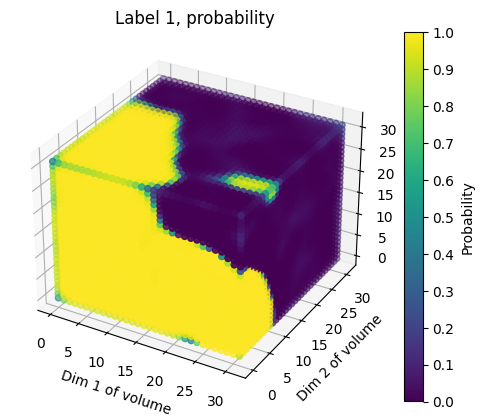

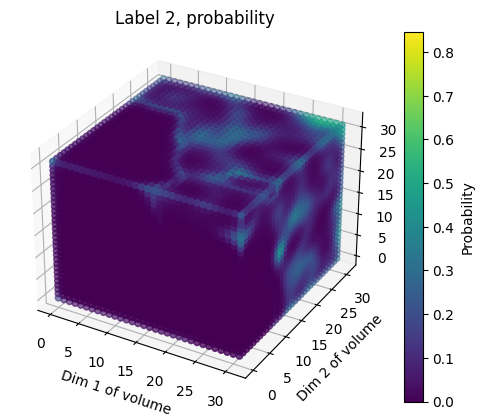

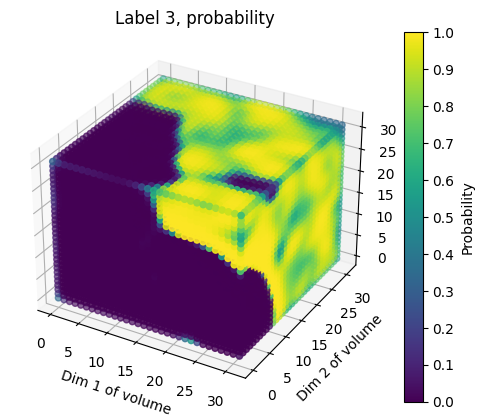

In [58]:
label1=output[0,0,:,:,:].cpu().detach().numpy()
label2=output[0,1,:,:,:].cpu().detach().numpy()
label3=output[0,2,:,:,:].cpu().detach().numpy()

x, y, z = np.meshgrid(np.arange(label1.shape[0]),np.arange(label1.shape[1]),np.arange(label1.shape[2]), indexing='ij')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Plot 3D surface
im1=ax.scatter(x, y, z, c=label1.flatten(), cmap='viridis', marker='o')
plt.title('Label 1, probability')
ax.set_xlabel('Dim 1 of volume')
ax.set_ylabel('Dim 2 of volume')
ax.set_zlabel('Dim 3 of volume')
fig.colorbar(im1,label='Probability',ticks=np.linspace(0, 1, 11))
plt.title('Label 1, probability')
# Show the plot
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Plot 3D surface
im2=ax.scatter(x, y, z, c=label2.flatten(), cmap='viridis', marker='o')
plt.title('Label 2, probability')
ax.set_xlabel('Dim 1 of volume')
ax.set_ylabel('Dim 2 of volume')
ax.set_zlabel('Dim 3 of volume')
fig.colorbar(im2,label='Probability',ticks=np.linspace(0, 1, 11))
# Show the plot
plt.show()


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Plot 3D surface
im3=ax.scatter(x, y, z, c=label3.flatten(), cmap='viridis', marker='o')
ax.set_xlabel('Dim 1 of volume')
ax.set_ylabel('Dim 2 of volume')
ax.set_zlabel('Dim 3 of volume')
fig.colorbar(im3,label='Probability',ticks=np.linspace(0, 1, 11))
# Show the plot
plt.title('Label 3, probability')
plt.show()

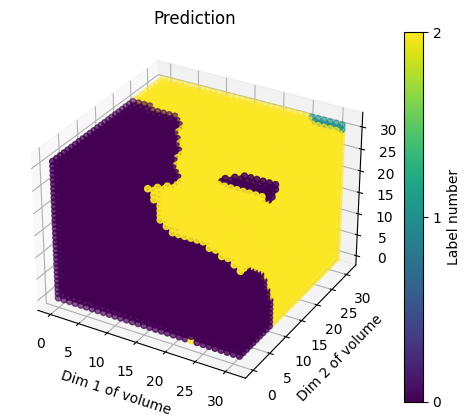

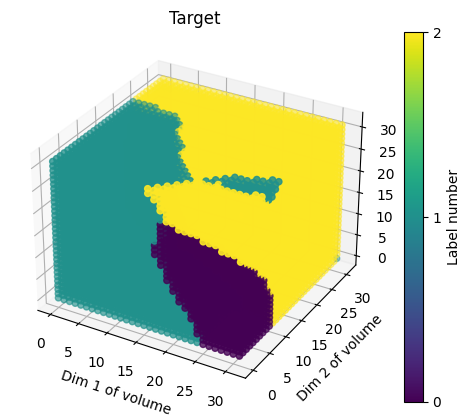

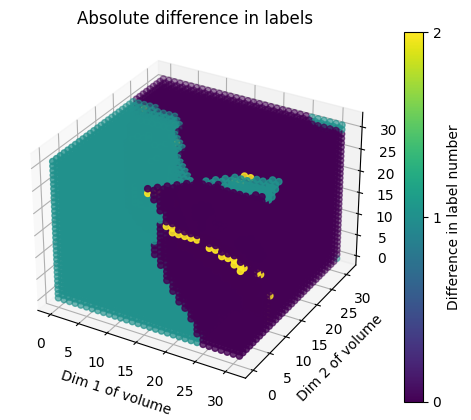

In [59]:
_, predicted=output.max(dim=1)

predicted=predicted.cpu().detach().numpy() [0,:,:,:]

x, y, z = np.meshgrid(np.arange(label1.shape[0]),np.arange(label1.shape[1]),np.arange(label1.shape[2]), indexing='ij')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
im=ax.scatter(x, y, z, c=predicted.flatten(), cmap='viridis', marker='o')
ax.set_xlabel('Dim 1 of volume')
ax.set_ylabel('Dim 2 of volume')
ax.set_zlabel('Dim 3 of volume')
fig.colorbar(im,ticks=[0,1,2],label='Label number')
plt.title('Prediction')
plt.show()

targets=targets.cpu().detach().numpy() [0,:,:,:]
x, y, z = np.meshgrid(np.arange(label1.shape[0]),np.arange(label1.shape[1]),np.arange(label1.shape[2]), indexing='ij')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
im2=ax.scatter(x, y, z, c=targets.flatten(), cmap='viridis', marker='o')
ax.set_xlabel('Dim 1 of volume')
ax.set_ylabel('Dim 2 of volume')
ax.set_zlabel('Dim 3 of volume')
fig.colorbar(im2,ticks=[0,1,2],label='Label number')
plt.title('Target')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
im3=ax.scatter(x, y, z, c=np.abs(targets.flatten()-predicted.flatten()), cmap='viridis', marker='o')
ax.set_xlabel('Dim 1 of volume')
ax.set_ylabel('Dim 2 of volume')
ax.set_zlabel('Dim 3 of volume')
fig.colorbar(im3,ticks=[0,1,2],label='Difference in label number')
plt.title('Absolute difference in labels')
plt.show()



